# Degassing Station — Monthly Energy Analysis
Load monthly data, engineer features, visualize relationships, fit multiple regression models, and export predictions.
- Targets: **fuel_gas** and **electricity**
- Drivers: throughput, water cut, GOR, ambient temp, CDD, lags/rolling means, interactions


c:\working\Data Prediction plotting\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,count,mean,std,min,median,max,RMS
crude,12.0,26338.279007,1344.147672,23667.064520,26451.661290,28044.064520,26369.700660
water,0.0,NaN,NaN,NaN,NaN,NaN,NaN
gas,12.0,60.174891,8.090366,47.677419,61.631183,73.387097,60.671386
amb_temp,12.0,29.240905,6.845997,20.525806,29.592849,38.687097,29.966524
fuel_gas,12.0,2.204102,0.178983,1.886542,2.167927,2.474663,2.210753
electricity,12.0,1867.695750,152.763097,1527.993000,1938.980750,2036.047000,1873.413800


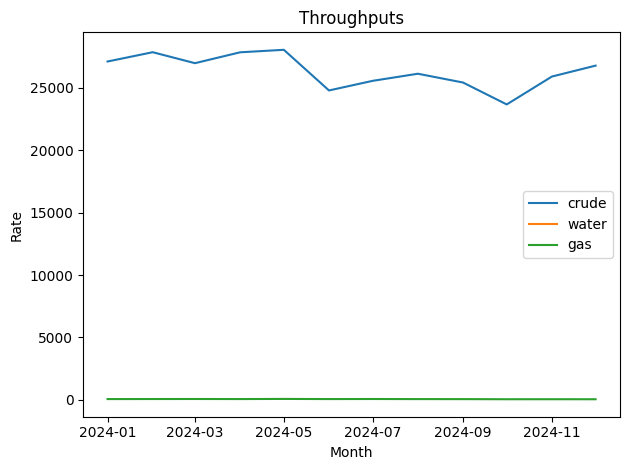

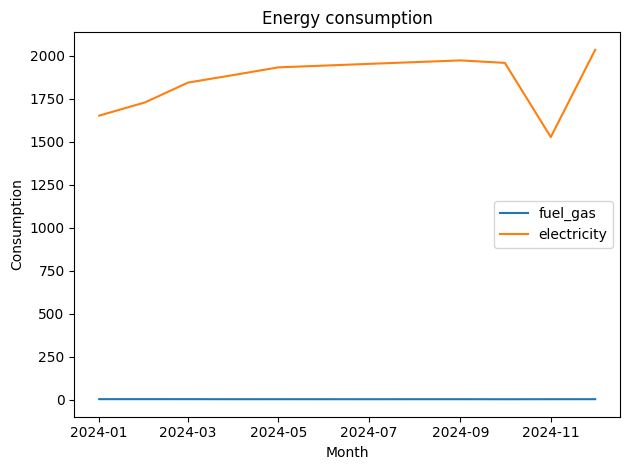

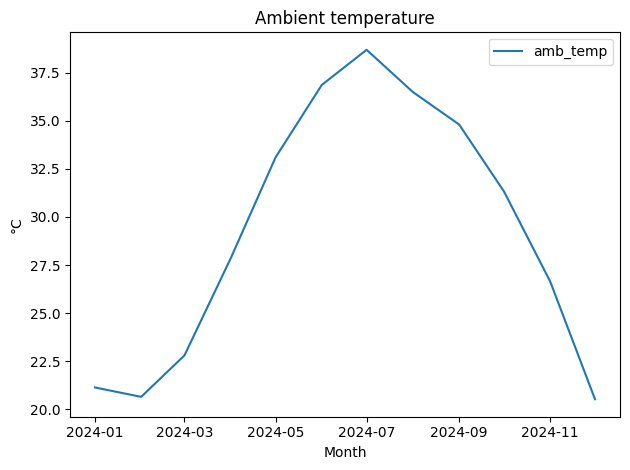

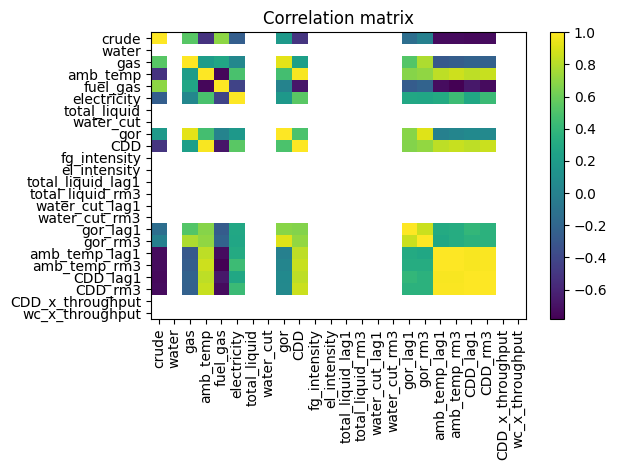

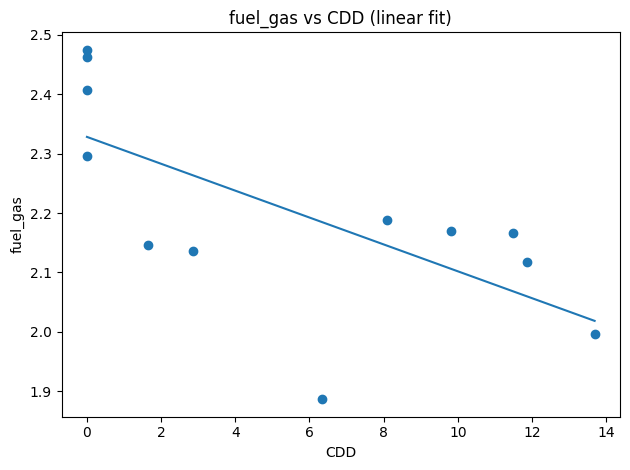

ValueError: Cannot have number of folds=3 greater than the number of samples=0.

In [4]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def ensure_datetime_monthly(s):
    s = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return s.dt.to_period("M").dt.to_timestamp()

def add_features(df, base_temp=25.0):
    out = df.copy()
    out["total_liquid"] = out["crude"].astype(float) + out["water"].astype(float)
    out["water_cut"] = out["water"] / out["total_liquid"].replace(0, np.nan)
    out["gor"] = out["gas"] / out["crude"].replace(0, np.nan)
    out["CDD"] = (out["amb_temp"] - base_temp).clip(lower=0)
    out["fg_intensity"] = out["fuel_gas"] / out["total_liquid"].replace(0, np.nan)
    out["el_intensity"] = out["electricity"] / out["total_liquid"].replace(0, np.nan)
    for c in ["total_liquid","water_cut","gor","amb_temp","CDD"]:
        out[f"{c}_lag1"] = out[c].shift(1)
        out[f"{c}_rm3"] = out[c].rolling(3, min_periods=1).mean()
    out["CDD_x_throughput"] = out["CDD"] * out["total_liquid"]
    out["wc_x_throughput"] = out["water_cut"] * out["total_liquid"]
    return out

def fit_and_eval(df, target, features, holdout=6):
    dfm = df.dropna(subset=[target] + features).copy()
    if len(dfm) < (holdout + 6):
        holdout = max(1, min(3, len(dfm)//4))
    X = dfm[features].values
    y = dfm[target].values
    X_train, X_test = X[:-holdout], X[-holdout:]
    y_train, y_test = y[:-holdout], y[-holdout:]

    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01, max_iter=10000),
        "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
    }
    rows, fitted = [], {}
    tscv = TimeSeriesSplit(n_splits=min(5, max(2, len(X)//6)))

    for name, model in models.items():
        rmse_cv, mape_cv, r2_cv = [], [], []
        for tr, te in tscv.split(X_train):
            model.fit(X_train[tr], y_train[tr])
            yh = model.predict(X_train[te])
            rmse_cv.append((mean_squared_error(y_train[te], yh))**0.5)
            mape_cv.append(mean_absolute_percentage_error(y_train[te], yh))
            r2_cv.append(r2_score(y_train[te], yh))
        model.fit(X_train, y_train)
        yhat = model.predict(X_test)
        rows.append({
            "Model": name,
            "CV_RMSE": np.mean(rmse_cv),
            "CV_MAPE": np.mean(mape_cv),
            "CV_R2": np.mean(r2_cv),
            "Test_RMSE": (mean_squared_error(y_test, yhat))**0.5,
            "Test_MAE": mean_absolute_error(y_test, yhat),
            "Test_MAPE": mean_absolute_percentage_error(y_test, yhat),
            "Test_R2": r2_score(y_test, yhat),
        })
        fitted[name] = model

    metrics = pd.DataFrame(rows).sort_values("Test_RMSE").reset_index(drop=True)
    best = metrics.iloc[0]["Model"]
    best_model = fitted[best]

    # In-sample predictions for plotting/export
    pred_full = best_model.predict(X)
    pred_series = pd.Series(pred_full, index=dfm.index[:len(pred_full)], name=f"pred_{target}_{best}")
    return metrics, best, best_model, pred_series

# --- Load & clean
raw = pd.read_csv('monthly.csv')
date_col = next((c for c in raw.columns if 'date' in c.lower() or 'month' in c.lower() or 'period' in c.lower()), raw.columns[0])
def pick(*keys):
    for c in raw.columns:
        cl = c.lower()
        if any(k in cl for k in keys): return c
    return None
crude_col = pick('crude','oil'); water_col = pick('water')
gas_col = pick('gas'); amb_col = pick('amb','ambient','temperature','temp')
fg_col = pick('fuel_gas','fuel gas','gas fuel','fg','fuel')
el_col = pick('electric','electricity','power','kwh','mwh')

df = pd.DataFrame({
    "date": ensure_datetime_monthly(raw[date_col]),
    "crude": pd.to_numeric(raw[crude_col], errors='coerce') if crude_col else np.nan,
    "water": pd.to_numeric(raw[water_col], errors='coerce') if water_col else np.nan,
    "gas": pd.to_numeric(raw[gas_col], errors='coerce') if gas_col else np.nan,
    "amb_temp": pd.to_numeric(raw[amb_col], errors='coerce') if amb_col else np.nan,
    "fuel_gas": pd.to_numeric(raw[fg_col], errors='coerce') if fg_col else np.nan,
    "electricity": pd.to_numeric(raw[el_col], errors='coerce') if el_col else np.nan,
}).sort_values("date").set_index("date")

for c in df.columns: df[c] = df[c].interpolate(limit_direction="both")
feat = add_features(df)

# --- Summary
summary = df.agg(['count','mean','std','min','median','max']).T
summary['RMS'] = [(np.mean(np.square(pd.to_numeric(df[c], errors="coerce").dropna())))**0.5 if c in df else np.nan for c in summary.index]
display(summary)

# --- Plots (matplotlib only; one chart per figure)
plt.figure(); 
for c in ['crude','water','gas']:
    if c in df.columns: plt.plot(df.index, df[c], label=c)
plt.title('Throughputs'); plt.xlabel('Month'); plt.ylabel('Rate'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); 
for c in ['fuel_gas','electricity']:
    if c in df.columns: plt.plot(df.index, df[c], label=c)
plt.title('Energy consumption'); plt.xlabel('Month'); plt.ylabel('Consumption'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); 
if 'amb_temp' in df.columns:
    plt.plot(df.index, df['amb_temp'], label='amb_temp')
    plt.title('Ambient temperature'); plt.xlabel('Month'); plt.ylabel('°C'); plt.legend(); plt.tight_layout(); plt.show()

corr = feat.select_dtypes(include=[float,int]).corr()
plt.figure(); 
plt.imshow(corr, aspect='auto'); plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation matrix'); plt.tight_layout(); plt.show()

# Driver-response scatter with linear fit (example pairs)
pairs = [
    ('fuel_gas','total_liquid'), ('fuel_gas','CDD'),
    ('electricity','total_liquid'), ('electricity','water_cut'),
]
for y, x in pairs:
    if y in df.columns and x in feat.columns:
        xv = feat[x].values; yv = df[y].values
        m = ~np.isnan(xv) & ~np.isnan(yv)
        if m.sum() >= 3:
            coef = np.polyfit(xv[m], yv[m], 1)
            xp = np.linspace(np.nanmin(xv[m]), np.nanmax(xv[m]), 50)
            yp = coef[0]*xp + coef[1]
            plt.figure(); plt.scatter(xv[m], yv[m]); plt.plot(xp, yp)
            plt.title(f'{y} vs {x} (linear fit)'); plt.xlabel(x); plt.ylabel(y); plt.tight_layout(); plt.show()

# --- Modeling
targets = [c for c in ['fuel_gas','electricity'] if c in df.columns]
feature_cols = [c for c in [
    "total_liquid","water_cut","gor","CDD","amb_temp",
    "total_liquid_lag1","water_cut_lag1","gor_lag1","amb_temp_lag1","CDD_lag1",
    "total_liquid_rm3","water_cut_rm3","gor_rm3","amb_temp_rm3","CDD_rm3",
    "CDD_x_throughput","wc_x_throughput"
] if c in feat.columns]

all_metrics = {}
pred_cols = {}
for t in targets:
    m, best, mdl, pred_series = fit_and_eval(feat, t, feature_cols, holdout=6)
    display(m)
    # Plot actual vs predicted (best model)
    plt.figure(); plt.plot(df.index, df[t].values, label=f'Actual {t}')
    aligned = pred_series.reindex(df.index)
    plt.plot(df.index, aligned.values, label=f'Pred ({best})')
    plt.title(f'Actual vs Predicted — {t} (best: {best})'); plt.xlabel('Month'); plt.ylabel(t); plt.legend(); plt.tight_layout(); plt.show()
    all_metrics[t] = m
    pred_cols[t] = aligned.rename(f'pred_{t}_{best}')

# Export outputs
final = feat.copy()
for t, s in pred_cols.items():
    final[s.name] = s
final.reset_index().to_csv('monthly_with_features_and_predictions.csv', index=False)
corr.to_csv('correlation_matrix.csv', index=True)
summary.to_csv('summary_stats.csv', index=True)
print('Saved: monthly_with_features_and_predictions.csv, correlation_matrix.csv, summary_stats.csv')


Slope: -0.2416060464619024
Intercept: 805418954.1294488
R²: 2.0400939336862045e-05


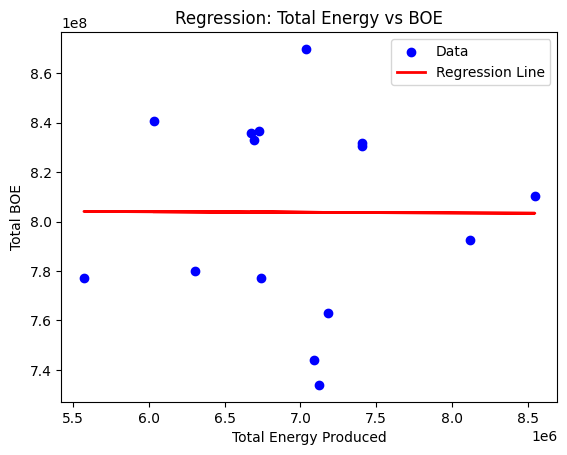

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Data provided
energy = np.array([
    6034690.176,
    6306355.064,
    6725538.618,
    6670919.975,
    7036433.32,
    7089730.357,
    8120466.422,
    8547721.608,
    7178616.24,
    7121155.984,
    5570468.529,
    7407887.445,
    6694252.259,
    6740891.152,
    7405792.859
])

boe = np.array([
    840653812.7,
    780161224.5,
    836524392.5,
    835666561.2,
    869772754.1,
    743970270.2,
    792674353.1,
    810264303.4,
    762985166.4,
    733947547.1,
    777301295.5,
    830334256.1,
    833153262.3,
    776989906.9,
    831600910.9
])

# Reshape for sklearn (expects 2D input for X)
X = energy.reshape(-1, 1)
y = boe

# Fit linear regression
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Get coefficients and R²
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, y_pred)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r2)

# Plot scatter + regression line
plt.scatter(energy, boe, color="blue", label="Data")
plt.plot(energy, y_pred, color="red", linewidth=2, label="Regression Line")
plt.xlabel("Total Energy Produced")
plt.ylabel("Total BOE")
plt.title("Regression: Total Energy vs BOE")
plt.legend()
plt.show()


In [2]:
pip install matplotlib numpy pandas scikit-learn statsmodels openpyxl

  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp313-cp313-win_amd64.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
